In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
from sklearn import datasets
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.base import clone
import seaborn as sns

In [3]:
#load JS vis in the notebook for shap plots
shap.initjs() 

In [4]:
#Import Tree Models from scratch functions
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/TreeModelsFromScratch")

from DecisionTree import DecisionTree
from RandomForest import RandomForest
from SmoothShap import verify_shap_model, smooth_shap

## Classification

### Load data

In [5]:
# Load data
X, y = datasets.load_breast_cancer(return_X_y=True, as_frame=True)
X = X.iloc[:,:5] #only keep first five features for now

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Fit random forest model and create explainer

In [6]:
X_train

,mean radius,mean texture,mean perimeter,mean area,mean smoothness
68,9.029,17.33,58.79,250.5,0.10660
181,21.090,26.57,142.70,1311.0,0.11410
63,9.173,13.86,59.20,260.9,0.07721
248,10.650,25.22,68.01,347.0,0.09657
60,10.170,14.88,64.55,311.9,0.11340
...,...,...,...,...,...
71,8.888,14.64,58.79,244.0,0.09783
106,11.640,18.33,75.17,412.5,0.11420
270,14.290,16.82,90.30,632.6,0.06429
435,13.980,19.62,91.12,599.5,0.10600


In [7]:
# Train DecisionTree from scratch
clf_forest = RandomForest(n_trees=20, treetype="classification", random_state=42)
clf_forest.fit(X_train, y_train)

In [8]:
export_model = clf_forest.export_forest_for_SHAP()

In [9]:
#import model into shap tree explainer
explainer = shap.TreeExplainer(export_model)

In [10]:
# Verify shap model
verify_shap_model(clf_forest, explainer, X_train)

In [11]:
shap_values_inbag = explainer.shap_values(X_train)

In [12]:
print(f"Shape of test data: {X_train.shape}")
print(f"Shape of shap_values: {np.array(shap_values_inbag).shape}")

Shape of test data: (455, 5)
Shape of shap_values: (455, 5)


### Global feature importance

 The summary plot seems to be broken. Issue on GitHub is already opened. We have to wait till it is fixed or might need to downgrade shap or matplotlib 

In [13]:
#shap.summary_plot(shap_values_inbag, X_train)

### Local feature importance

In [14]:
# First observation in train set
shap.force_plot(explainer.expected_value, shap_values_inbag[0], features=X_train.iloc[0,:])

In [15]:
# First 10 observation in train set
shap.force_plot(explainer.expected_value, shap_values_inbag[:10], features=X_train.iloc[:10,:])

### Assess shap values array with regards to tree model

In [16]:
#Show first 5 obsv
shap_values_inbag[:5,:]

array([[ 0.01226666,  0.03757627,  0.23307829,  0.10914329, -0.01799857],
       [-0.02486137, -0.06859426, -0.30191341, -0.16834197, -0.06222306],
       [ 0.0101643 ,  0.1011093 ,  0.12715941,  0.07423094,  0.061402  ],
       [ 0.03784224, -0.07405853,  0.26039601,  0.15061911, -0.00073291],
       [ 0.01022269,  0.12346027,  0.20911562,  0.0909864 , -0.05971906]])

- Dimension of shap values array (n_rows: n_observation, n_colums: n_features of X dataset) 
- Features which have not been used by the model have a shap score of 0

### Smooth SHAP

#### Smooth SHAP using train and test data

For clarifying the smooth shap idea we first follow the idea presented by Markus to use a simplified approach by abandoning the inbag/oob approach and use separate train/test data instead

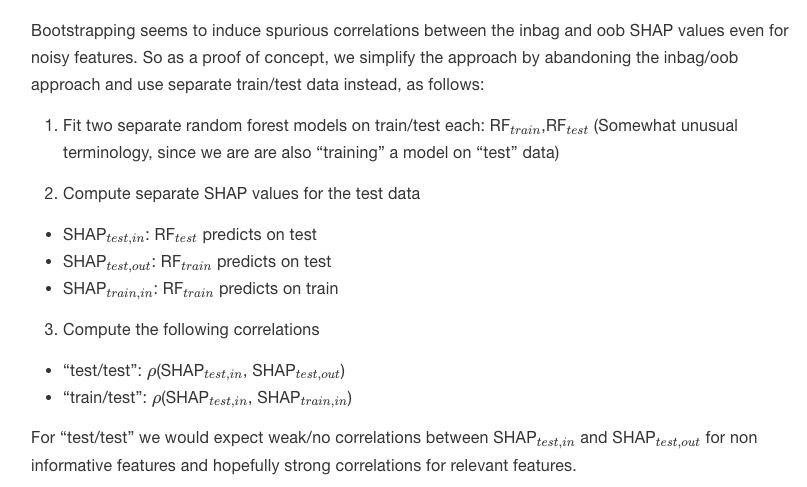

In [21]:
# Train RF on test and train
clf_forest_train = RandomForest(n_trees=5, treetype="classification", random_state=42)
clf_forest_test = RandomForest(n_trees=5, treetype="classification", random_state=42)

#Fit
clf_forest_train.fit(X_train, y_train)
clf_forest_test.fit(X_test, y_test)

#export for shap
export_model_train = clf_forest_train.export_forest_for_SHAP()
export_model_test = clf_forest_test.export_forest_for_SHAP()

#import model into shap tree explainer
explainer_train = shap.TreeExplainer(export_model_train)
explainer_test = shap.TreeExplainer(export_model_test)

# Verify shap model
verify_shap_model(clf_forest_train, explainer_train, X_train)
verify_shap_model(clf_forest_test, explainer_test, X_test)

45 out of 455 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
9 out of 114 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score


In [22]:
# Calculate shap scores
shap_test_in = explainer_test.shap_values(X_test)
shap_test_out = explainer_train.shap_values(X_test)

In [23]:
# Get correlation of shap scores per feature
corrs = []
for i in range(shap_test_in.shape[1]):
    corrs.append(np.corrcoef(shap_test_in[:,i], shap_test_out[:,i])[0,1])
    
corrs

[0.8229885186602505,
 0.5783102746005458,
 0.7436916925750038,
 0.9414939755988933,
 0.6777650854392069]

Now we will fit a linear model for each feature
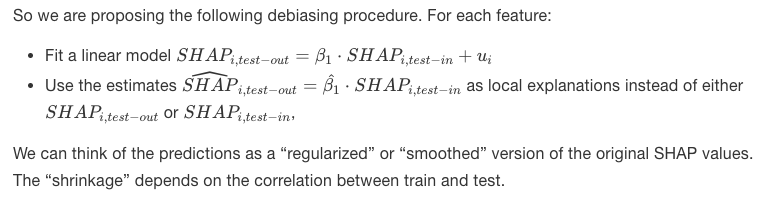

In [24]:
# Fit linear models for each feature
lin_models = []
preds = []

for i in range(shap_test_in.shape[1]):
    linear_reg = LinearRegression().fit(shap_test_in[:,i].reshape(-1, 1), shap_test_out[:,i])
    lin_models.append(clone(linear_reg))
    preds.append(linear_reg.predict(shap_test_in[:,i].reshape(-1, 1)))


In [25]:
# Mean smooth shap value per feature
smooth_shap_vals = np.mean(preds, axis=1)
smooth_shap_vals

array([ 0.01573641, -0.01943326, -0.02352027,  0.00909043, -0.0205315 ])

Smooth SHAP score for feature 4 seems rather small. This might indicate that this feature is uninformative.

### Test whether mean of shap scores from individual trees == shap scores of forest 

In [26]:
# Train RF with 2 trees
clf_forest_ = RandomForest(n_trees=2, treetype="classification", random_state=42)
clf_forest_.fit(X_train, y_train)

#export for shap
export_model_forest = clf_forest_.export_forest_for_SHAP()

#import model into shap tree explainer
explainer_forest = shap.TreeExplainer(export_model_forest)

# Verify shap model
verify_shap_model(clf_forest_, explainer_forest, X_train)

shap_forest = explainer_forest.shap_values(X_test)

169 out of 455 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score


In [27]:
# Export trees of forest
export_tree1 = clf_forest_.trees[0].export_tree_for_SHAP()
export_tree2 = clf_forest_.trees[1].export_tree_for_SHAP()

explainer_tree1 = shap.TreeExplainer(export_tree1)
explainer_tree2 = shap.TreeExplainer(export_tree2)

verify_shap_model(clf_forest_.trees[0], explainer_tree1, X_train)
verify_shap_model(clf_forest_.trees[1], explainer_tree2, X_train)

shap_tree1 = explainer_tree1.shap_values(X_test)
shap_tree2 = explainer_tree2.shap_values(X_test)

In [28]:
np.mean((shap_tree1[0],shap_tree2[0]), axis=0)

array([-0.0194269 , -0.05690242,  0.06428925,  0.01293805, -0.62946941])

In [29]:
shap_forest[0]

array([-0.0194269 , -0.05690242,  0.06428925,  0.01293805, -0.62946941])

The mean shap scores are equal to the forest shap score

Lets see how we can do it in numpy

In [30]:
shap_scores_arr = np.full([X_test.shape[0], X_test.shape[1], clf_forest_.n_trees], np.nan)

In [31]:
shap_scores_arr[:,:,0]=shap_tree1
shap_scores_arr[:,:,1]=shap_tree2

In [32]:
#Thats how to do it in numpy
np.nanmean(shap_scores_arr, axis=2)[0]

array([-0.0194269 , -0.05690242,  0.06428925,  0.01293805, -0.62946941])

#### Test class functionality to compute SHAP oob

In [33]:
clf_forest_ = RandomForest(n_trees=2, treetype="classification", oob_SHAP=True, random_state=42)
clf_forest_.fit(X_train, y_train)

#export for shap
export_model_forest = clf_forest_.export_forest_for_SHAP()

#import model into shap tree explainer
explainer_forest = shap.TreeExplainer(export_model_forest)

# Verify shap model
verify_shap_model(clf_forest_, explainer_forest, X_train)

shap_forest = explainer_forest.shap_values(X_train)

169 out of 455 samples do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates. These samples were dropped before computing the oob_score
Mean of empty slice
Mean of empty slice


In [34]:
clf_forest_.inbag_SHAP_values[0]

array([ 0.00705815,  0.03742603,  0.30999057,  0.0089503 , -0.00518329])

In [35]:
clf_forest_.oob_SHAP_values[0]

array([ 0.26774273,  0.04137934,  0.09637725,  0.01056344, -0.03144736])

In [36]:
# The first oob was predicted by first tree of ensemble
clf_forest_.oob_preds_tree_id[0]

[0]

In [37]:
#lets compare sahp from this tree vs the shap oob_score and inbag score
export_tree1 = clf_forest_.trees[0].export_tree_for_SHAP()
export_tree2 = clf_forest_.trees[1].export_tree_for_SHAP()

explainer_tree1 = shap.TreeExplainer(export_tree1)
explainer_tree2 = shap.TreeExplainer(export_tree2)

verify_shap_model(clf_forest_.trees[0], explainer_tree1, X_train)
verify_shap_model(clf_forest_.trees[1], explainer_tree2, X_train)

shap_tree1 = explainer_tree1.shap_values(X_train)
shap_tree2 = explainer_tree2.shap_values(X_train)

In [38]:
# test if oob_SHAP_values of first tree of ensemble (which has NOT seen the first obs during fit) is equal to shap values of newly fitted shap model 
assert shap_tree1[0].all()==clf_forest_.oob_SHAP_values[0].all()

In [39]:
# test if inbag_SHAP_values of 2nd tree of ensemble (which has seen the first obs during fit) is equal to shap values of newly fitted shap model 
assert shap_tree1[1].all()==clf_forest_.inbag_SHAP_values[0].all()

This is correct :) 

In [40]:
# lets try another sample where multiple trees predicted
clf_forest_.oob_preds_tree_id[2]

[0, 1]

In [41]:
np.mean((shap_tree1[2],shap_tree2[2]), axis=0)

array([0.14190511, 0.07668571, 0.09054178, 0.02852567, 0.03377029])

In [42]:
clf_forest_.oob_SHAP_values[2]

array([0.14190511, 0.07668571, 0.09054178, 0.02852567, 0.03377029])

This also looks correct :) 

### Calculate smooth SHAP values
Lets calculate smooth shap

In [43]:
clf_forest_20 = RandomForest(n_trees=20, treetype="classification", oob_SHAP=True, random_state=42)
clf_forest_20.fit(X_train, y_train)

#export for shap
export_model_forest20 = clf_forest_20.export_forest_for_SHAP()

#import model into shap tree explainer
explainer_forest20 = shap.TreeExplainer(export_model_forest20)

# Verify shap model
verify_shap_model(clf_forest_20, explainer_forest20, X_train)

#shap_forest = explainer_forest.shap_values(X_train)

In [44]:
clf_forest_20.inbag_SHAP_values[:,1].mean()

0.0017215294781595517

In [45]:
clf_forest_20.oob_SHAP_values[:,0].mean()

-0.00023799659401373504

In [76]:
preds, smooth_shap_val, lin_models, shap_values_inbag, shap_values_oob = smooth_shap(clf_forest_20.inbag_SHAP_values, clf_forest_20.oob_SHAP_values, detailed_output=True)


In [77]:
clf_forest_20.oob_SHAP_values.mean(axis=0)

array([-0.000238  , -0.00071435, -0.0007767 , -0.00034365,  0.00094134])

In [78]:
smooth_shap_val

array([-0.000238  , -0.00071435, -0.0007767 , -0.00034365,  0.00094134])

In [79]:
shap_values_oob[:,0].mean()

-0.00023799659401373504

In [80]:
preds[0].mean()

-0.00023799659401373504

In [81]:
from sklearn.metrics import mean_squared_error
for i in range(len(preds)):
    print(mean_squared_error(shap_values_oob[:,i], preds[i]))

0.0009975532563243517
0.005784982346812364
0.009132143936497104
0.008096384862728954
0.006428919540858985


- shap smooth global mean == mean shap oob ?! - >wegen linear regression fit on oob values?
- deswegen Anmerkung von Markus bzgl. "local" -> also return die preds uns nutze diese als explanation (locally)
- Ggf auch weil mse so klein ist ? --> Teste anderes Dataset

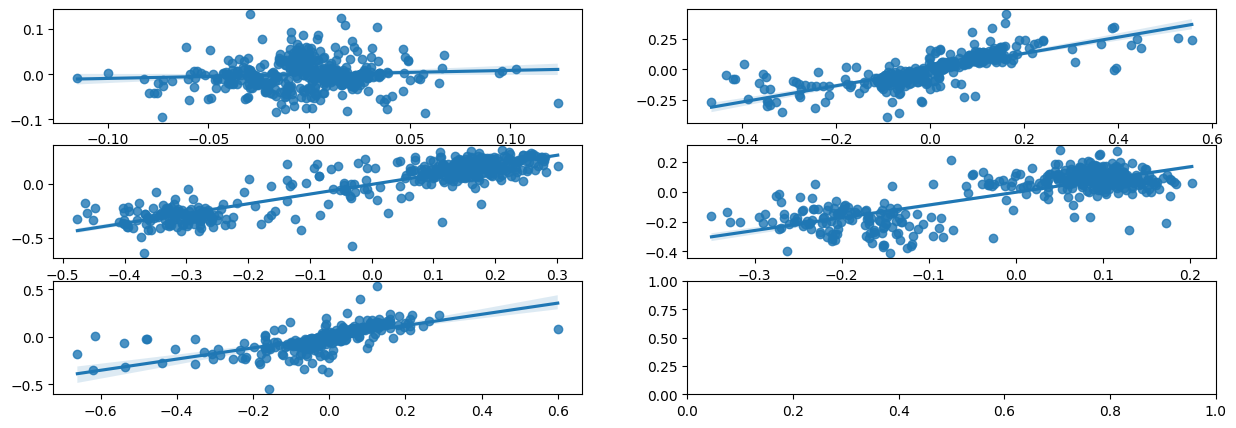

In [82]:
fig, axs = plt.subplots(3,2,figsize=(15,5))
sns.regplot(x=clf_forest_20.inbag_SHAP_values[:,0], y=clf_forest_20.oob_SHAP_values[:,0], ax=axs[0,0])
sns.regplot(x=clf_forest_20.inbag_SHAP_values[:,1], y=clf_forest_20.oob_SHAP_values[:,1], ax=axs[0,1])
sns.regplot(x=clf_forest_20.inbag_SHAP_values[:,2], y=clf_forest_20.oob_SHAP_values[:,2], ax=axs[1,0])
sns.regplot(x=clf_forest_20.inbag_SHAP_values[:,3], y=clf_forest_20.oob_SHAP_values[:,3], ax=axs[1,1])
sns.regplot(x=clf_forest_20.inbag_SHAP_values[:,4], y=clf_forest_20.oob_SHAP_values[:,4], ax=axs[2,0]);

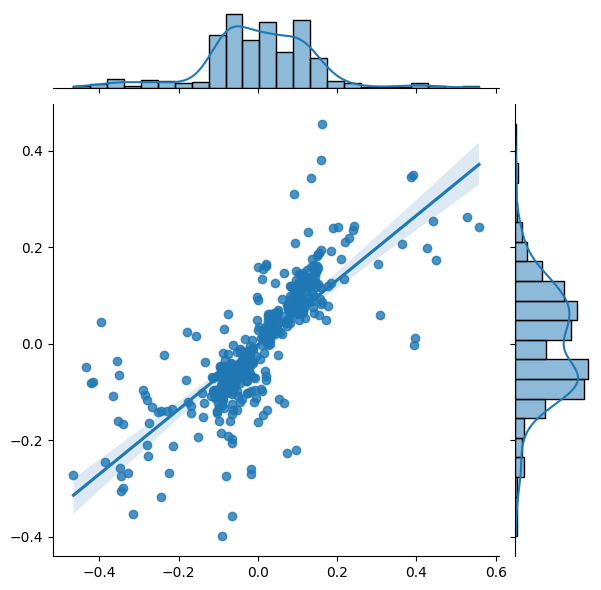

In [53]:
sns.jointplot(x=clf_forest_20.inbag_SHAP_values[:,1], y=clf_forest_20.oob_SHAP_values[:,1], kind="reg")

## Regression

In [86]:
X_dia, y_dia = datasets.load_diabetes(return_X_y=True, as_frame=True)

### Fit random forest model and create explainer

In [170]:
# Train DecisionTree from scratch
reg_forest = RandomForest(n_trees=20, treetype="regression", oob_SHAP=True, random_state=42)
reg_forest.fit(X_dia, y_dia)

export_model_reg = reg_forest.export_forest_for_SHAP()

#import model into shap tree explainer
explainer_reg = shap.TreeExplainer(export_model_reg)

# Verify shap model
verify_shap_model(reg_forest, explainer_reg, X_dia)

"is not" with a literal. Did you mean "!="?


### Compute smooth shap

In [126]:
reg_smooth_shap_val, reg_smooth_shap_mean, reg_lin_models, reg_shap_values_inbag, reg_shap_values_oob = smooth_shap(
    reg_forest.inbag_SHAP_values, reg_forest.oob_SHAP_values, detailed_output=True
)

In [127]:
reg_smooth_shap_mean

array([-0.1563364 , -0.1059559 ,  0.78782272,  0.10120593, -0.08938018,
        0.53415416,  0.6823095 , -0.19672474,  0.77299687,  0.24381824])

In [128]:
reg_forest.oob_SHAP_values.mean(axis=0)

array([-0.1563364 , -0.1059559 ,  0.78782272,  0.10120593, -0.08938018,
        0.53415416,  0.6823095 , -0.19672474,  0.77299687,  0.24381824])

mean of OOB shap and mean of smooth shap p. feature still are identical 

In [130]:
for i in range(reg_smooth_shap_val.shape[1]):
    print(mean_squared_error(reg_shap_values_oob[:,i], reg_smooth_shap_val[:,i]))

31.357354185135407
5.951948028515979
228.75924868507224
72.2166173883726
13.747629668162624
25.606953877276137
46.98587680982715
13.873117986674687
251.193327055683
55.93513551314448


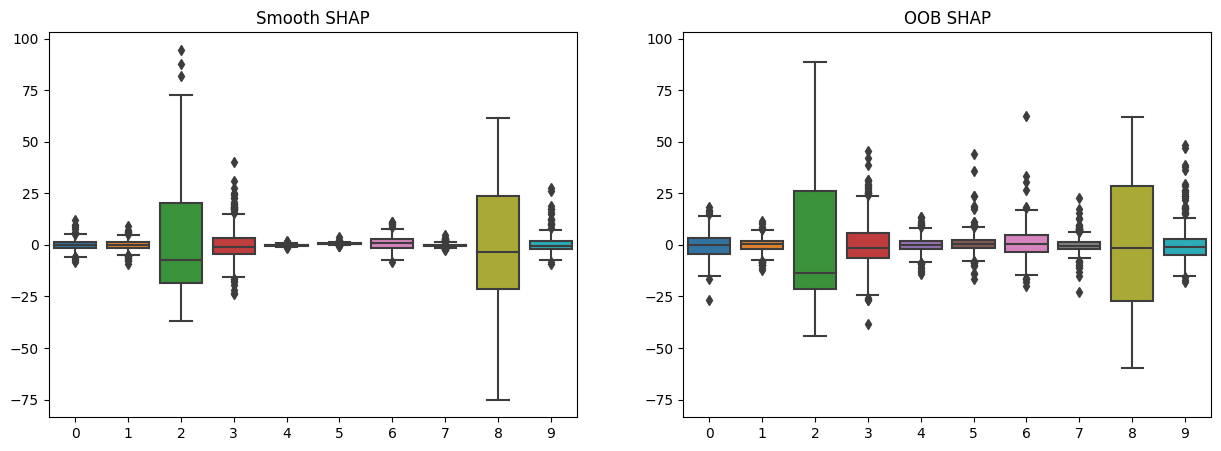

In [148]:
# Comparison Smooth SHAP vs OOB SHAP value distribution p feature
fig, axs = plt.subplots(1,2,figsize=(15,5))

sns.boxplot(reg_smooth_shap_val, ax =axs[0])
sns.boxplot(reg_forest.oob_SHAP_values, ax =axs[1])

axs[0].set_title("Smooth SHAP")
axs[1].set_title("OOB SHAP")
plt.setp(axs, ylim=axs[0].get_ylim());